In [710]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz as gr
import networkx as nx
import statsmodels.api as sm 
import seaborn as sns

from statsmodels.stats.proportion import proportion_confint
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from dowhy import gcm
from sklearn.ensemble import RandomForestClassifier

from sklearn.isotonic import IsotonicRegression

from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.utils import shuffle

In [477]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [478]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [479]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Text(0, 0.5, 'count')

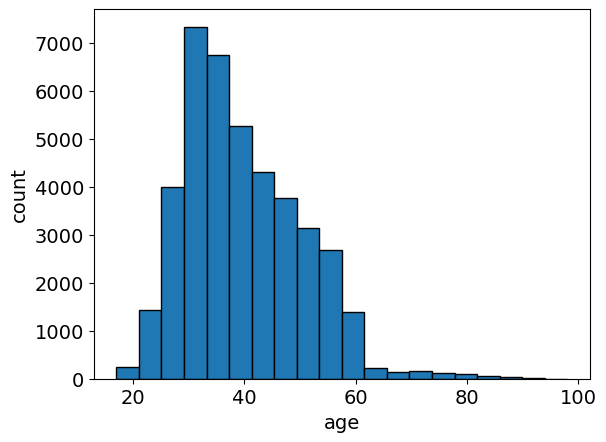

In [480]:
plt.hist(df.age, bins = 20, edgecolor = 'black')

plt.xlabel("age")
plt.ylabel("count")

<Axes: xlabel='count', ylabel='y'>

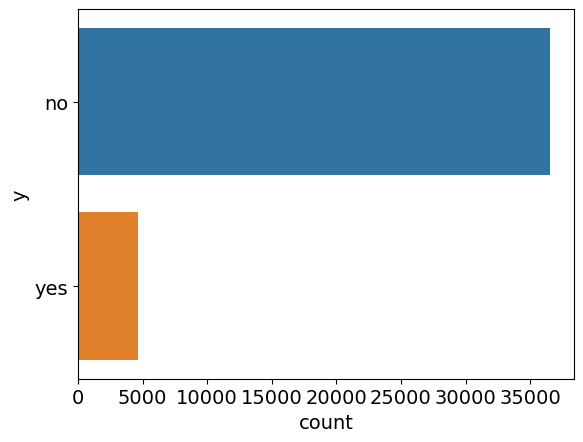

In [481]:
sns.barplot(x = df.y.value_counts(), y = df.y.value_counts().index)

In [482]:
pd.DataFrame([df.default.value_counts(), df.loan.value_counts(), df.housing.value_counts(),
             ])

,no,unknown,yes
count,32588,8597,3
count,33950,990,6248
count,18622,990,21576


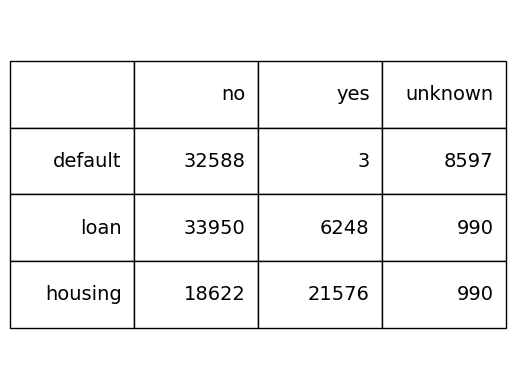

In [483]:
tab = [['', 'no', 'yes', 'unknown'],
       ['default', '32588', '3', '8597'],
       ['loan', '33950', '6248', '990'],
       ['housing', '18622', '21576', '990']]


fig, ax = plt.subplots()

table = ax.table(tab, loc = 'center')

table.set_fontsize (14)
table. scale (1,4)
ax.axis('off')

#  1. Обработка данных

In [484]:
cols_to_rename = {
    'emp.var.rate': 'emp_var_rate',
    'cons.price.idx': 'cons_price_idx',
    'cons.conf.idx': 'cons_conf_idx',
    'euribor3m': 'euribor_3m',
    'nr.employed': 'num_employed',
    'y': 'target'
}

df = df.rename(columns = cols_to_rename)

In [485]:
cols_translate = {
    ### персональные данные
    'age': 'возраст',
    'job': 'место работы',
    'martial': 'семейное положение',
    'default': 'наличие кредита с просрочкой',
    'housing': 'наличие ипотеки',
    'loan': 'наличие кредита',
    ### данные о последней коммуникации текущей компании
    'contact': 'тип связи',
    'month': 'последний месяц контакта',
    'day_of_week': 'день недели последнего контакта',
    'duration': 'продолжительность звонка',
    ### другие атрибуты
    'campaign': 'количество контактов, осуществленных в ходе данной кампании и для данного клиента',
    'pdays': 'количество дней, прошедших после того, как с клиентом в последний раз контакта с клиентом в рамках предыдущей кампании',
    'previous': 'предыдущие: количество контактов, осуществленных до этой кампании и для этого клиента ',
    'poutcome': 'результат предыдущей маркетинговой кампании',
    ### атрибуты социального и экономического характера
    'emp_var_rate': 'employment variation rate - коэффициент занятости',
    'cons_price_idx': 'consumer price index - индекс потребительских цен',
    'cons_conf_idx': 'consumer confidence index - индекс потребительского доверия',
    'euribor_3m': 'euribor 3 month rate - европейская межбанковская ставка предложения',
    'num_employed': 'number of employees - количество работников',
    ### таргет
    'target': 'оформил ли клиент срочный вклад'
}


In [486]:
pd.set_option('display.max_columns', None)


In [487]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,num_employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [488]:
binary_dict = {
    'yes': 1,
    'no': 0,
    'unknown': -1
}

contact_dict = {
    'cellular': 1,
    'telephone': 0
}


poutcome_dict = {
    'nonexistent': -1,
    'failure': 0,
    'success': 1
}

target_dict = {
    'no': 0,
    'yes': 1
}

In [489]:
def multi_label_encoder(df, col):
    
    temp_dict = {}
    value_cnt = df[col].value_counts()

    for i in range(value_cnt.shape[0]):
        temp_dict[value_cnt.index[i]] = i
    
    return temp_dict


def get_encoded_column(df, col, encode_dict):
    
    func_df = df.copy()
    
    for i in range(func_df.shape[0]):
        func_df.loc[i, col] = encode_dict[func_df.loc[i, col]]

        
    return func_df[col]

In [490]:
df['job'] = get_encoded_column(df, 'job', multi_label_encoder(df, 'job')).astype(np.int64)
df['marital'] = get_encoded_column(df, 'marital', multi_label_encoder(df, 'marital')).astype(np.int64)
df['education'] = get_encoded_column(df, 'education', multi_label_encoder(df, 'education')).astype(np.int64)
df = df.drop('default', axis = 1)
df['housing'] = get_encoded_column(df, 'housing', binary_dict).astype(np.int64)
df['loan'] =  get_encoded_column(df, 'loan', binary_dict).astype(np.int64)
df['contact'] =  get_encoded_column(df, 'contact', contact_dict).astype(np.int64)
df = df.drop('month', axis = 1)
df = df.rename(columns = {'month': 'quarter'})
df = df.drop('day_of_week', axis = 1)
df.loc[df['pdays'] == 999, 'pdays'] = -1
df['poutcome'] =  get_encoded_column(df, 'poutcome', poutcome_dict).astype(np.int64)
df['target'] =  get_encoded_column(df, 'target', target_dict).astype(np.int64)

df = df.drop(['emp_var_rate','cons_price_idx','cons_conf_idx','euribor_3m','num_employed'], axis = 1)

#df['duration'] = pd.qcut(df.duration, q = 10, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).astype(int)


In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        41188 non-null  int64
 1   job        41188 non-null  int64
 2   marital    41188 non-null  int64
 3   education  41188 non-null  int64
 4   housing    41188 non-null  int64
 5   loan       41188 non-null  int64
 6   contact    41188 non-null  int64
 7   duration   41188 non-null  int64
 8   campaign   41188 non-null  int64
 9   pdays      41188 non-null  int64
 10  previous   41188 non-null  int64
 11  poutcome   41188 non-null  int64
 12  target     41188 non-null  int64
dtypes: int64(13)
memory usage: 4.1 MB


In [492]:
df.to_csv('обработанный датасет.csv', sep = ';', index = False)

# 2. Анализ

Признаки для анализа
* contact
* campaign
* duration


In [805]:
df.age_bucket = [0] * df.shape[0]


In [806]:
for i in range(df.shape[0]):
    if df.loc[i, 'age'] <= 22:
        df.loc[i, 'age_bucket'] = '17-22'
    elif df.loc[i, 'age'] > 22 and df.loc[i, 'age'] <= 30:
        df.loc[i, 'age_bucket'] = '23-30'
    elif df.loc[i, 'age'] > 30 and df.loc[i, 'age'] <= 40:
        df.loc[i, 'age_bucket'] = '31-40'
    elif df.loc[i, 'age'] > 40 and df.loc[i, 'age'] <= 50:
        df.loc[i, 'age_bucket'] = '41-50'
    elif df.loc[i, 'age'] > 50:
        df.loc[i, 'age_bucket'] = '50+'

In [807]:
df

,age,job,marital,education,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,age_bucket
0,56,8,0,4,0,0,0,261,1,-1,0,-1,0,50+
1,57,3,0,1,0,0,0,149,1,-1,0,-1,0,50+
2,37,3,0,1,1,0,0,226,1,-1,0,-1,0,31-40
3,40,0,0,5,0,0,0,151,1,-1,0,-1,0,31-40
4,56,3,0,1,0,1,0,307,1,-1,0,-1,0,50+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,0,3,1,0,1,334,1,-1,0,-1,1,50+
41184,46,1,0,3,0,0,1,383,1,-1,0,-1,0,41-50
41185,56,5,0,0,1,0,1,189,2,-1,0,-1,0,50+
41186,44,2,0,3,0,0,1,442,1,-1,0,-1,1,41-50


# Contact

Text(0, 0.5, 'Возраст')

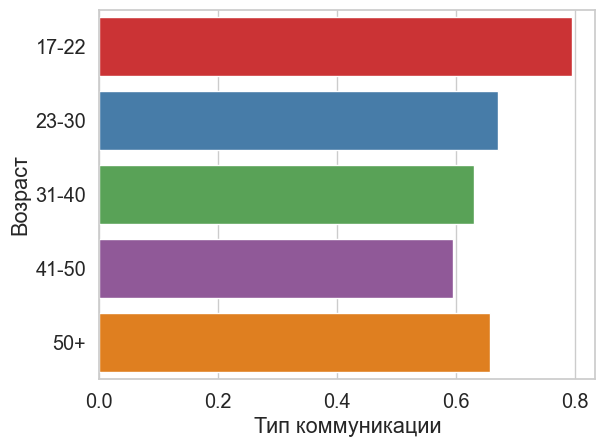

In [972]:
sns.barplot(x = df.groupby('age_bucket')["contact"].mean(), y = df.groupby('age_bucket')["contact"].mean().index)

plt.xlabel('Тип коммуникации')
plt.ylabel('Возраст')

<Axes: xlabel='contact'>

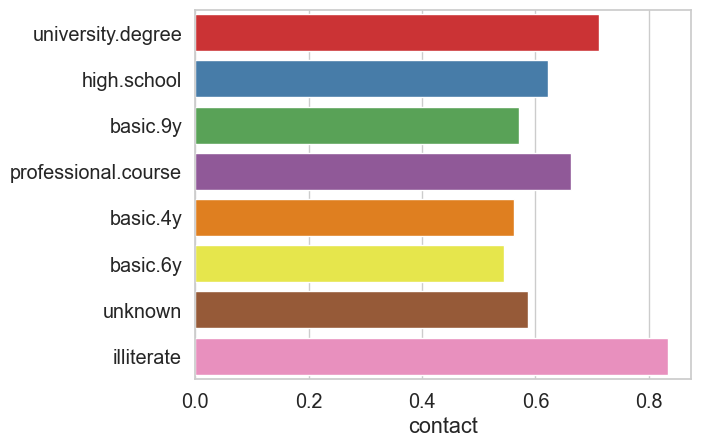

In [795]:
edu_codes = ['university.degree', 'high.school', 'basic.9y',
             'professional.course', 'basic.4y', 'basic.6y', 'unknown', 'illiterate']

sns.barplot(x = df.groupby("education")["contact"].mean(), y = edu_codes)



<Axes: xlabel='contact'>

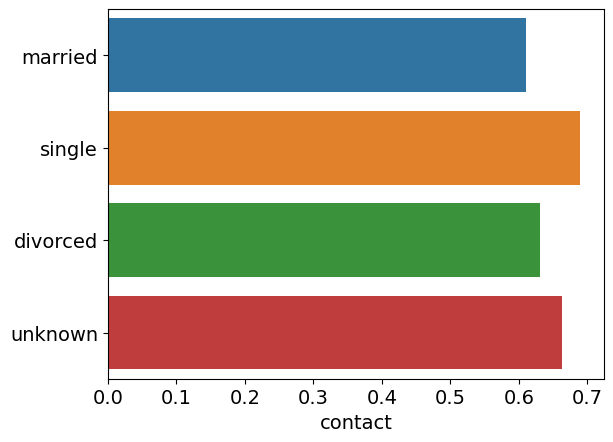

In [496]:
marital_codes = ['married', 'single', 'divorced', 'unknown']

sns.barplot(x = df.groupby("marital")["contact"].mean(), y = marital_codes)


<Axes: xlabel='contact'>

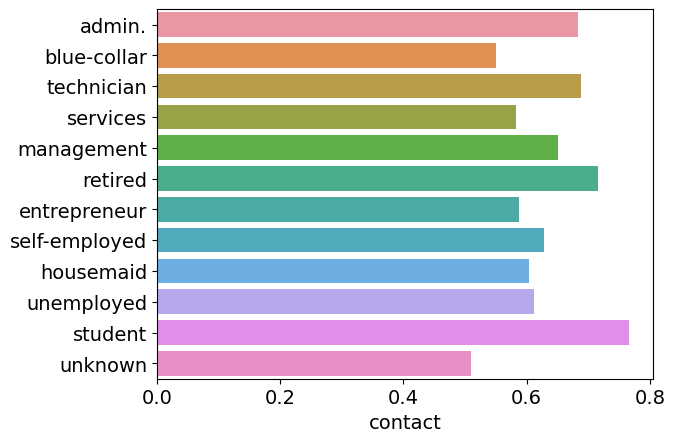

In [497]:
job_codes = ['admin.', 'blue-collar', 'technician', 'services', 'management', 'retired',
             'entrepreneur', 'self-employed', 'housemaid', 'unemployed', 'student', 'unknown']

sns.barplot(x = df.groupby("job")["contact"].mean(), y = job_codes)

## campaign

In [498]:
df[['age', 'campaign']].corr()

,age,campaign
age,1.000000,0.004594
campaign,0.004594,1.000000


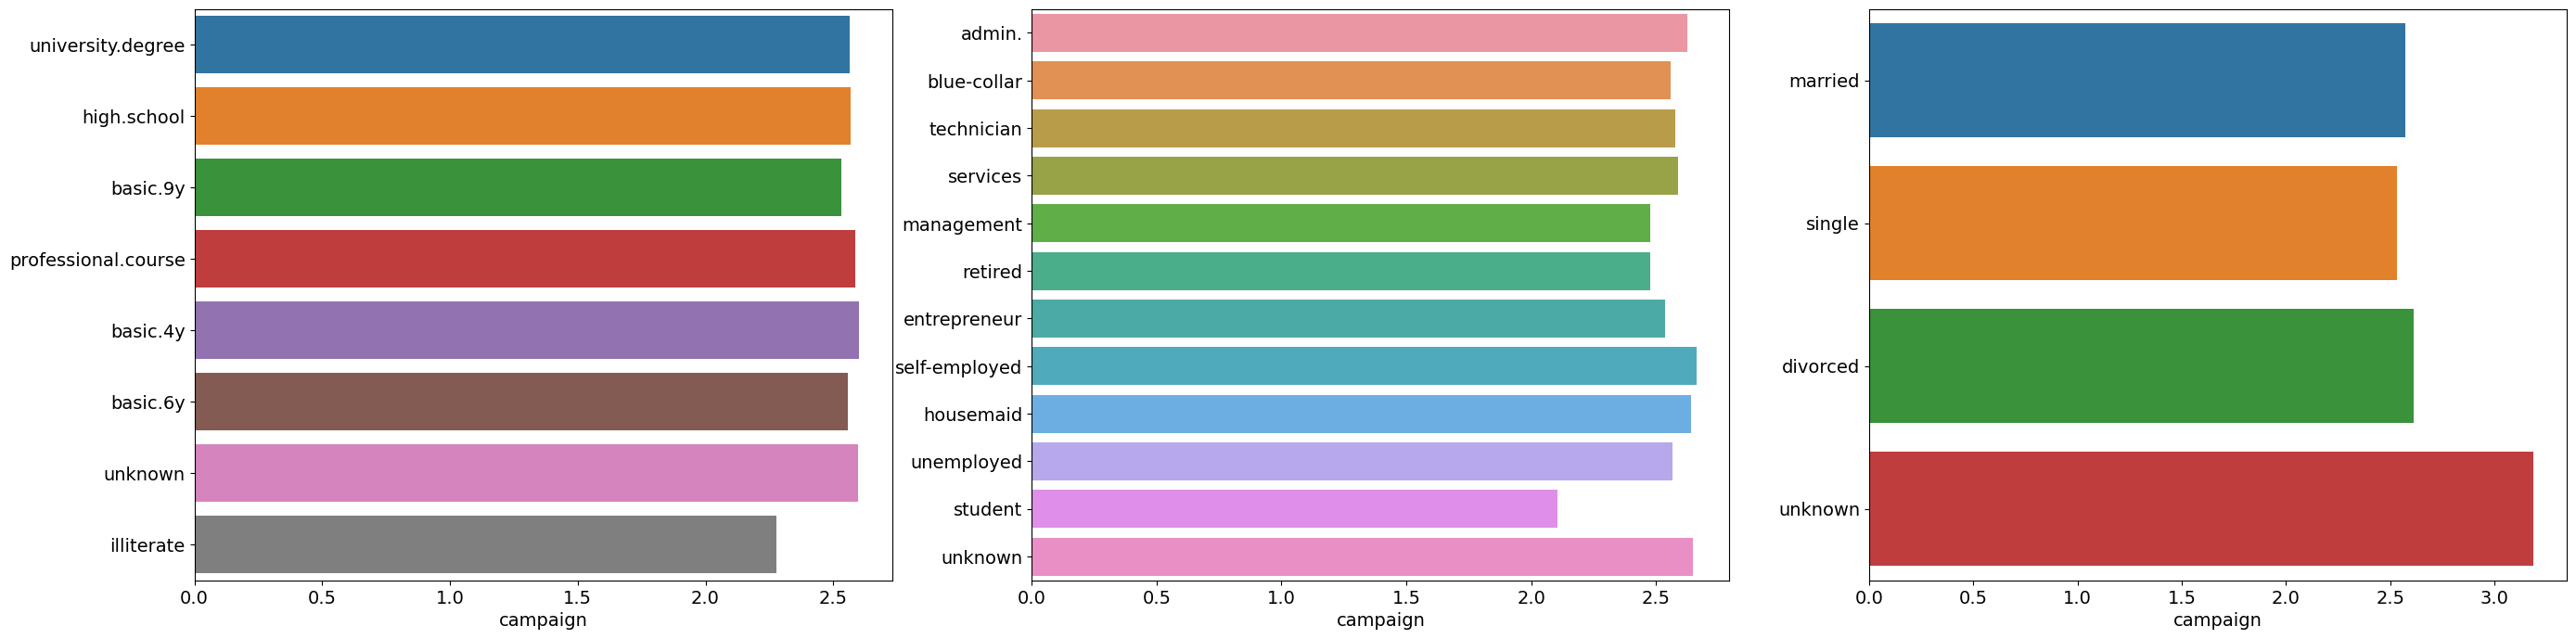

In [499]:
import matplotlib

matplotlib.rc('font', size=14)

plt.figure(figsize=(33, 8))
    
plt.subplot(131)
sns.barplot(x = df.groupby("education")["campaign"].mean(), y = edu_codes)
    
plt.subplot(132)
sns.barplot(x = df.groupby("job")["campaign"].mean(), y = job_codes)

plt.subplot(133)
sns.barplot(x = df.groupby("marital")["campaign"].mean(), y = marital_codes)

#plt.suptitle("Проверка на сопоставимость")
plt.show();

In [500]:
df.previous.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

## duration

In [501]:
df[['age', 'duration']].corr()

,age,duration
age,1.000000,-0.000866
duration,-0.000866,1.000000


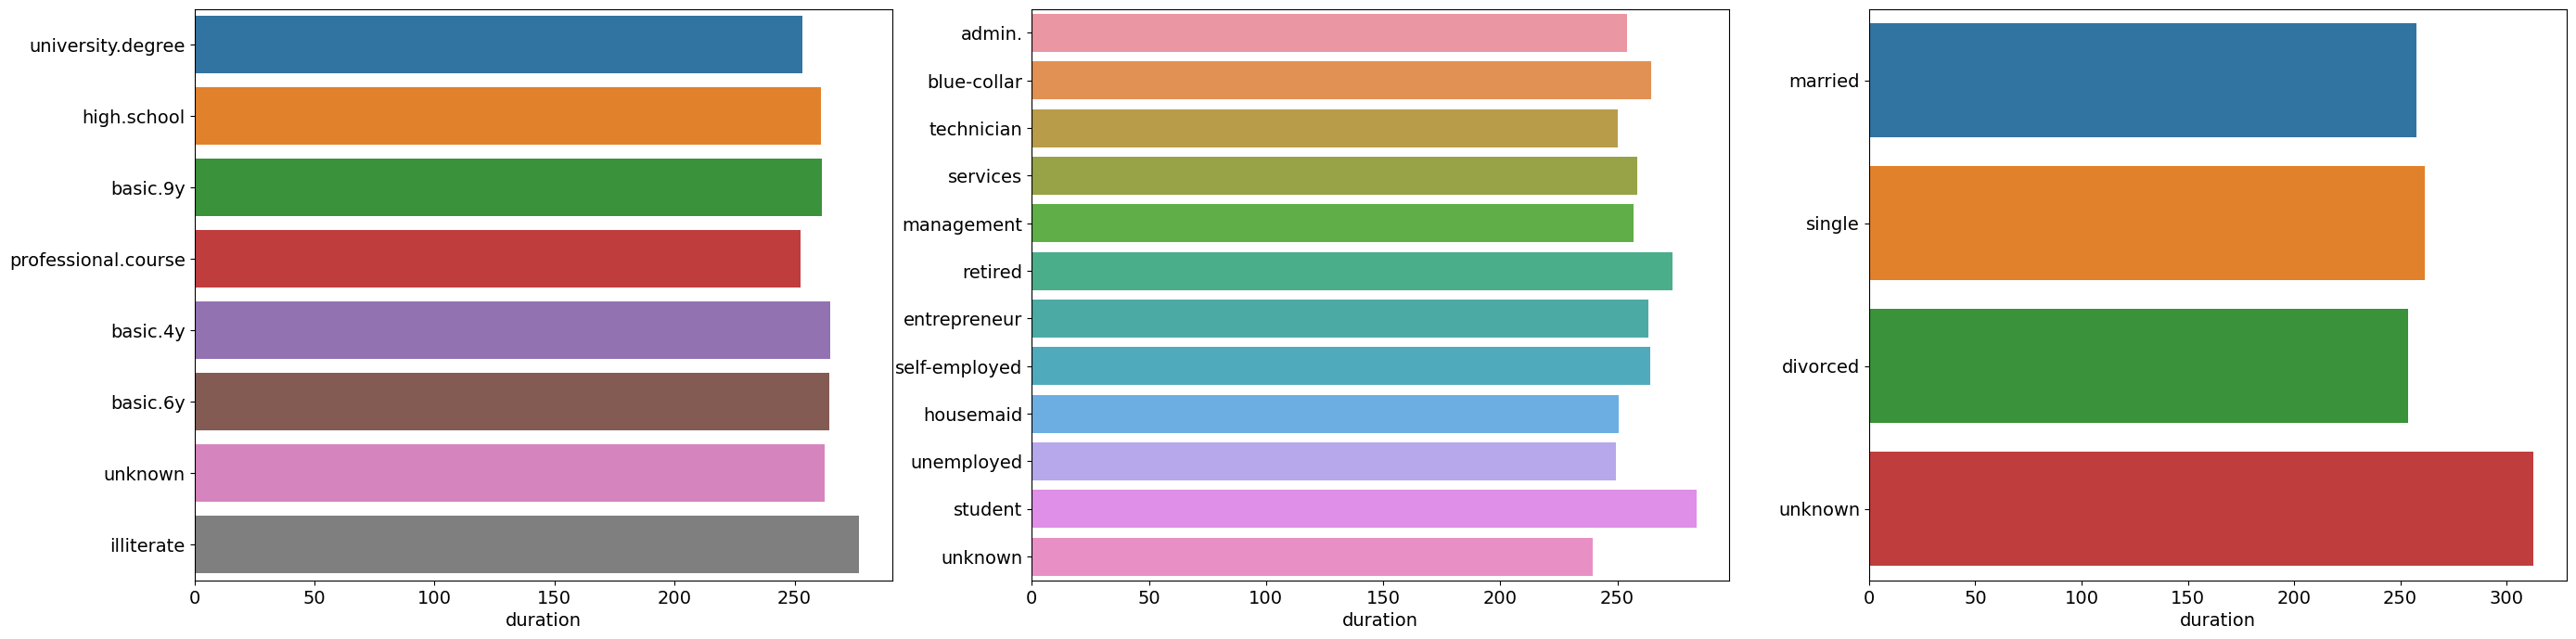

In [502]:


matplotlib.rc('font', size=14)

plt.figure(figsize=(33, 8))
    
plt.subplot(131)
sns.barplot(x = df.groupby("education")["duration"].mean(), y = edu_codes)
    
plt.subplot(132)
sns.barplot(x = df.groupby("job")["duration"].mean(), y = job_codes)

plt.subplot(133)
sns.barplot(x = df.groupby("marital")["duration"].mean(), y = marital_codes)

#plt.suptitle("Проверка на сопоставимость")
plt.show();

## previous

In [503]:
df[['age', 'previous']].corr()

,age,previous
age,1.000000,0.024365
previous,0.024365,1.000000


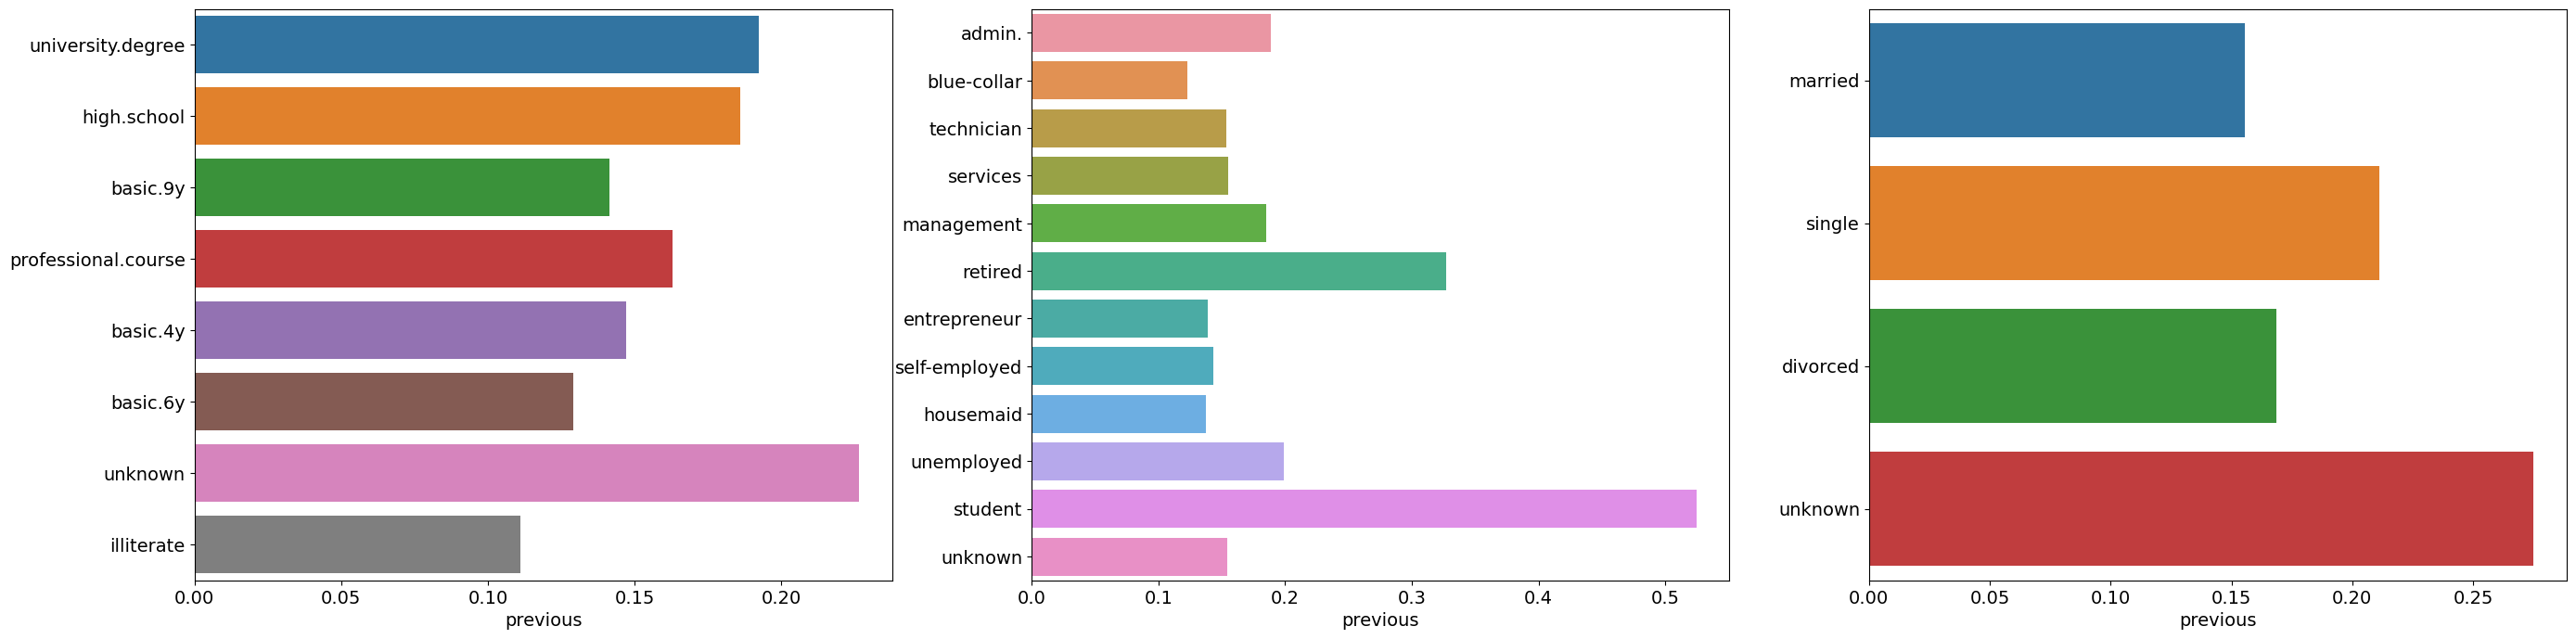

In [504]:
matplotlib.rc('font', size=14)

plt.figure(figsize=(33, 8))
    
plt.subplot(131)
sns.barplot(x = df.groupby("education")["previous"].mean(), y = edu_codes)
    
plt.subplot(132)
sns.barplot(x = df.groupby("job")["previous"].mean(), y = job_codes)

plt.subplot(133)
sns.barplot(x = df.groupby("marital")["previous"].mean(), y = marital_codes)

#plt.suptitle("Проверка на сопоставимость")
plt.show();

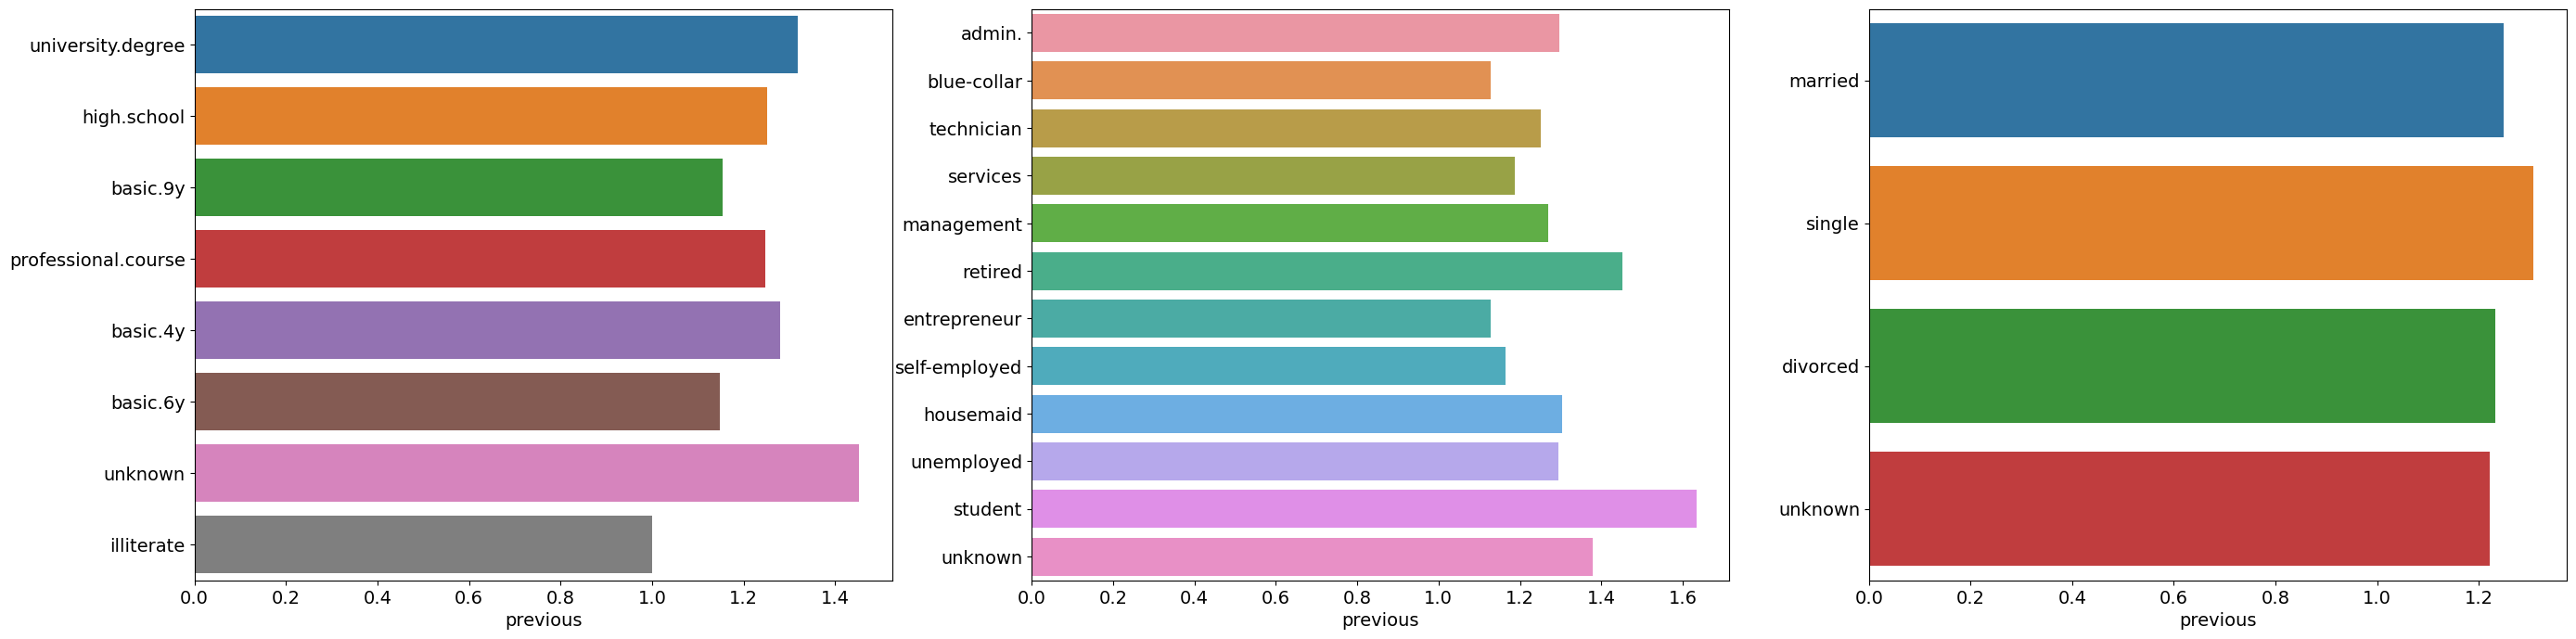

In [505]:
matplotlib.rc('font', size=14)

plt.figure(figsize=(33, 8))
    
plt.subplot(131)
sns.barplot(x = df[df.previous != 0].groupby("education")["previous"].mean(), y = edu_codes)
    
plt.subplot(132)
sns.barplot(x = df[df.previous != 0].groupby("job")["previous"].mean(), y = job_codes)

plt.subplot(133)
sns.barplot(x = df[df.previous != 0].groupby("marital")["previous"].mean(), y = marital_codes)

#plt.suptitle("Проверка на сопоставимость")
plt.show();

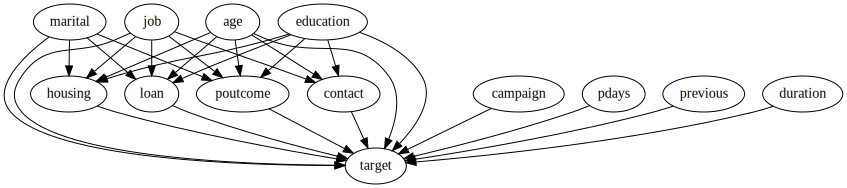

<Figure size 2000x800 with 0 Axes>

In [506]:
g = gr.Digraph()

g.edge("job", "housing")
g.edge("job", "loan")
g.edge("job", "poutcome")
g.edge("job", "contact")


g.edge("age", "housing")
g.edge("age", "loan")
g.edge("age", "poutcome")
g.edge("age", "contact")


g.edge("marital", "housing")
g.edge("marital", "loan")
g.edge("marital", "poutcome")

g.edge("education", "housing")
g.edge("education", "loan")
g.edge("education", "poutcome")
g.edge("education", "contact")


g.edge("age", "target")
g.edge("job", "target")
g.edge("marital", "target")
g.edge("education", "target")
g.edge("housing", "target")
g.edge("loan", "target")
g.edge("contact", "target")
g.edge("campaign", "target")
g.edge("pdays", "target")
g.edge("previous", "target")
g.edge("poutcome", "target")
g.edge("duration", "target")

plt.figure(figsize=(20, 8))
g

In [507]:
proportion_confint(df.query('contact==0').target.sum(), df.query('contact==0').target.count(), alpha = 0.05)

In [508]:
proportion_confint(df.query('contact==1').target.sum(), df.query('contact==1').target.count(), alpha = 0.05)

In [509]:
df.query('contact==0').target.sum() / df.query('contact==0').target.count()

In [510]:
df.query('contact==1').target.sum() / df.query('contact==1').target.count()

/var/folders/3f/wwj0290s09x08d0h9h6gxccr0000gn/T/ipykernel_14575/174314776.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values2, y_values2, 'bo', linestyle="--", label = "Первая группа", color = 'r')


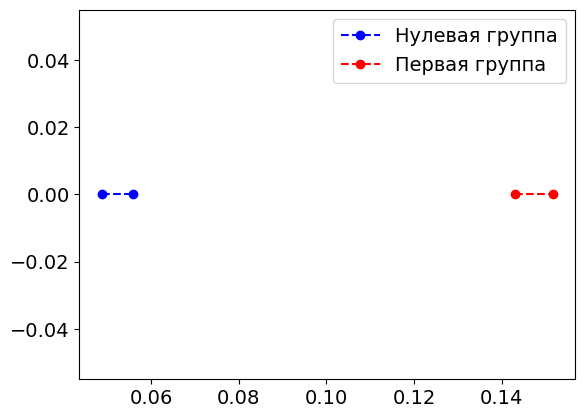

In [512]:
point1 = (0.0487552260309716, 0)
point2 = (0.0558712031102143, 0)
x_values1 = [point1[0], point2[0]]
y_values1 = [point1[1], point2[1]]
plt.plot(x_values1, y_values1, 'bo', linestyle="--", label = "Нулевая группа")

point3 = (0.143079180167696, 0)
point4 = (0.151672961815168, 0)
x_values2 = [point3[0], point4[0]]
y_values2 = [point3[1], point4[1]]
plt.plot(x_values2, y_values2, 'bo', linestyle="--", label = "Первая группа", color = 'r')
plt.legend()
#plt.text(point1[0]-0.015, point1[1]+0.25, "Point1")
#plt.text(point2[0]-0.050, point2[1]-0.25, "Point2")

## оценка с помощью лог рег

In [513]:
def get_logreg_summary(df):
    
    
    
    categ = ['job', 'marital', 'education'] 
    Y = 'target'
    
    df_with_categ = pd.concat([df.drop(columns=categ),
                               pd.get_dummies(df[categ], columns=categ, drop_first=False)], axis=1)
    
    
    X_train = df_with_categ.drop(Y, axis = 1).astype(float)
    Y_train = df_with_categ[Y]
    
    log_reg = sm.Logit(Y_train, X_train).fit()#fit_regularized(method='l1', alpha = 0.4) 
    
    print(log_reg.summary()) 

In [514]:
get_logreg_summary(df)

Optimization terminated successfully.
         Current function value: 0.246763
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41157
Method:                           MLE   Df Model:                           30
Date:                Tue, 14 May 2024   Pseudo R-squ.:                  0.2990
Time:                        22:00:40   Log-Likelihood:                -10164.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0086      0.002      3.840      0.000       0.004       0.013
housing         0.0319   

In [515]:
def get_logreg_estimate(df):
    
    
    categ = ['job', 'marital', 'education'] 
    Y = 'target'
    
    df_with_categ = pd.concat([df.drop(columns=categ),
                               pd.get_dummies(df[categ], columns=categ, drop_first=False)], axis=1)
    
    
    
    X_train = df_with_categ.drop(Y, axis = 1).astype(float)
    Y_train = df_with_categ[Y]
    
    log_reg = sm.Logit(Y_train, X_train).fit()#fit_regularized(method='l1', alpha = 0.4) 
    
    df_score = df.assign(score = log_reg.predict(X_train))
    
    
    return df_score.query('target == 1')['score'].mean() - df_score.query('target == 0')['score'].mean()

In [516]:
get_logreg_estimate(df)

Optimization terminated successfully.
         Current function value: 0.246763
         Iterations 12


## Оценка  сопоставления по переменной

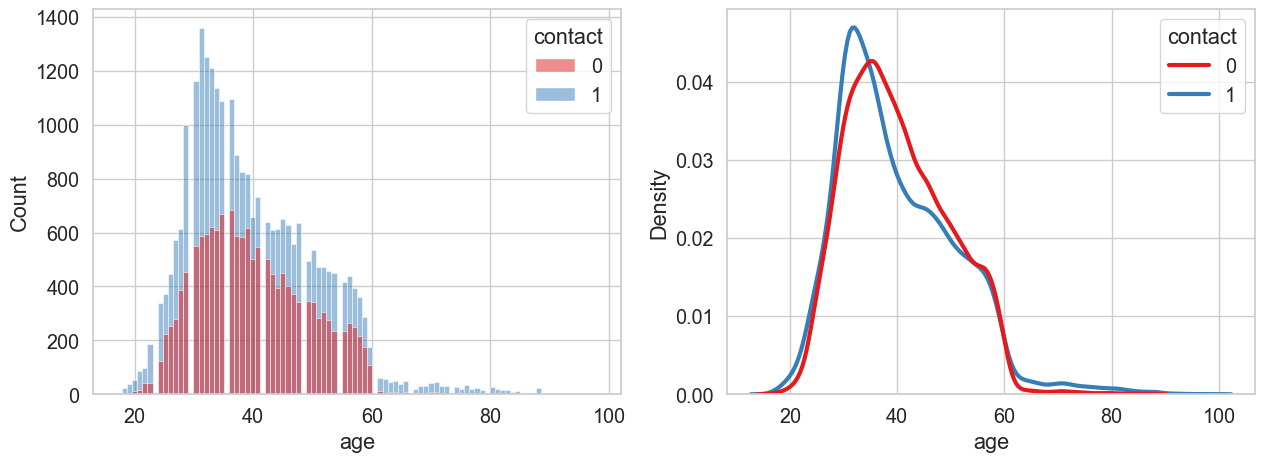

In [640]:
sns.set(font_scale=1.3, palette='Set1', style='whitegrid')

plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(data=df, x='age', hue='contact')
plt.subplot(122)
sns.kdeplot(data=df, x='age', 
        hue='contact', lw=3, common_norm=False)
#plt.suptitle("Проверка на сопоставимость распределений по возрасту")
plt.show();


In [645]:
def matching_feature_estimate(df, treatment, feature):
    
    df_id = df.assign(client_id = [i for i in range(df.shape[0])])
    
    treated = df_id[df[treatment] == 1]
    untreated = df_id[df[treatment] == 0]
    
    matches = pd.concat([
        shuffle(treated.merge(untreated, on="age", how="inner", suffixes=("_t_1", "_t_0"))).drop_duplicates('client_id_t_1'),
        shuffle(untreated.merge(treated, on="age", how="inner", suffixes=("_t_1", "_t_0"))).drop_duplicates('client_id_t_0')])
            

    ate = np.mean((2*matches[treatment + '_t_0'] - 1)*(matches['target_t_0'] - matches['target_t_1']))
    
    return ate


In [646]:
matching_feature_estimate(df, 'contact', 'age')

In [657]:
#np.random.seed(4444)

mf_estimations = []

for _ in (range(200)):
    
    tmp_df = df.sample(frac = 0.5, replace = True)
    mf_estimations.append(matching_feature_estimate(tmp_df, 'contact', 'age'))

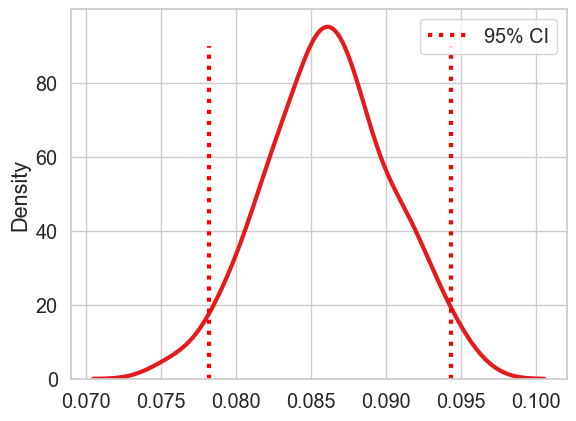

In [659]:
sns.kdeplot(mf_estimations, lw=3)
plt.vlines(np.percentile(mf_estimations, [2.5, 97.5]), 0, 90, 
           color='red', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

## оценка с помощью knn метчинга

In [662]:
def matching_knn_estimate(df, treatment):
    
    X = ['job', 'age', 'marital', 'education', 'housing', 'loan']
    y = 'target'

    treated = df.query(treatment+"==1")
    untreated = df.query(treatment+"==0")

    # эта модель находит наиболее похожего "непролеченных"
    mt0 = KNeighborsClassifier(n_neighbors=1, metric = 'euclidean').fit(untreated[X], untreated[y])
    # эта модель находит наиболее похожего "пролеченных"
    mt1 = KNeighborsClassifier(n_neighbors=1, metric = 'euclidean').fit(treated[X], treated[y])

    predicted = pd.concat([
        # для "пролеченного" находим наиболее похожего на него "непролеченного"
        treated.assign(match=mt0.predict(treated[X])),
        # для "непролеченного" находим наиболее похожего на него "пролеченного"
        untreated.assign(match=mt1.predict(untreated[X]))])

    return np.mean((2*predicted[treatment] - 1)*(predicted['target'] - predicted["match"]))

In [663]:
matching_knn_estimate(df, 'contact')

In [664]:
#np.random.seed(4444)

mknn_estimations = []

for _ in (range(200)):
    
    tmp_df = df.sample(frac = 0.5, replace = True)
    mknn_estimations.append(matching_knn_estimate(tmp_df, 'contact'))

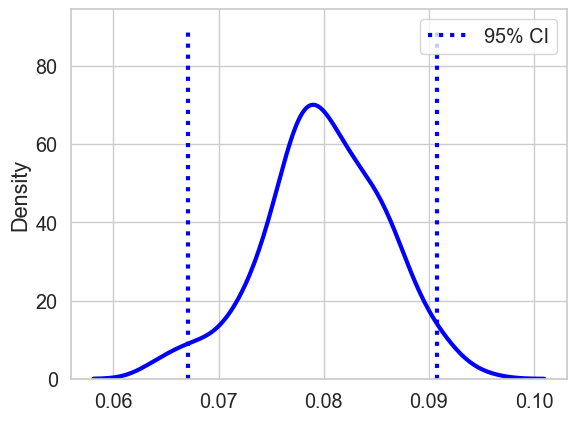

In [667]:
sns.kdeplot(mknn_estimations, lw=3, color = 'blue')
plt.vlines(np.percentile(mknn_estimations, [2.5, 97.5]), 0, 90, 
           color='blue', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

## Оценка propencity_score

In [693]:
def propensity_score_graphics(df, treatment, confaunders):
    
 
    ps_model = LogisticRegression().fit(df[confaunders], df[treatment])
    
    
    df_ps = df.assign(propensity_score=ps_model.predict_proba(df[confaunders])[:, 1])
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.histplot(data=df_ps, x='propensity_score', hue=treatment)
    plt.subplot(122)
    sns.kdeplot(data=df_ps, x='propensity_score', 
            hue=treatment, lw=3, common_norm=False)
    #plt.suptitle("Проверка на сопоставимость")
    plt.show();

    return df_ps

На графике видно, что группы являются сопоставимыми, и, для каждого объекта из первой группы существует объект из второй группы с равной оценкой вероятности. Но качество оценки не вполне состоятельное. Это связано с тем, что обучающая выборка содержит несколько категориальных переменных с большим количеством классов.

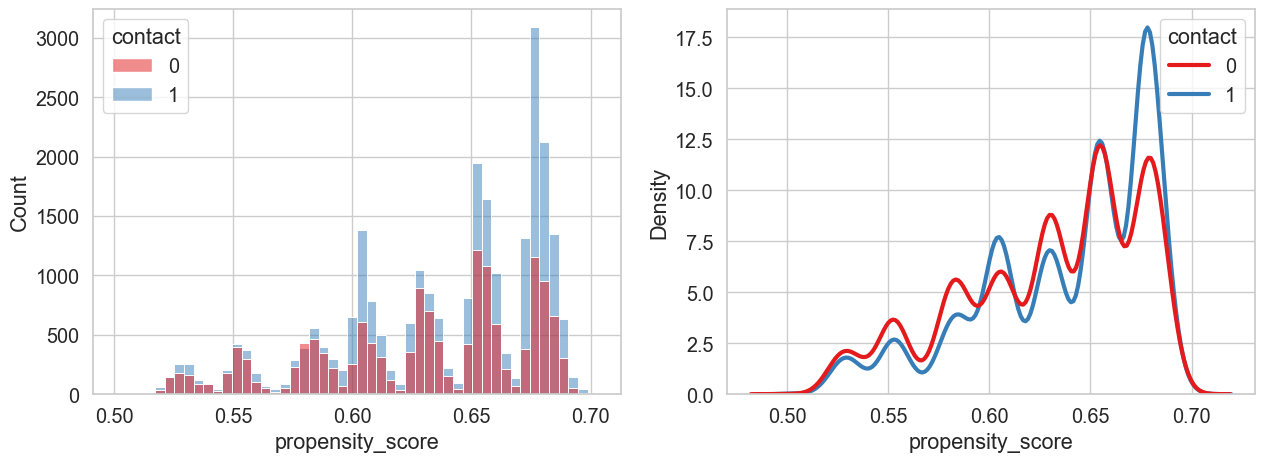

In [695]:
a = propensity_score_graphics(df, 'contact', ['age', 'job', 'education'])

In [696]:
def propensity_score_forest_graphics(df, treatment, confaunders):
    
 
    ps_model = RandomForestClassifier().fit(df[confaunders], df[treatment])
    
    
    df_ps = df.assign(propensity_score=ps_model.predict_proba(df[confaunders])[:, 1])
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.histplot(data=df_ps, x='propensity_score', hue=treatment)
    plt.subplot(122)
    sns.kdeplot(data=df_ps, x='propensity_score', 
            hue=treatment, lw=3, common_norm=False)
    #plt.suptitle("Проверка на сопоставимость")
    plt.show();

    return df_ps

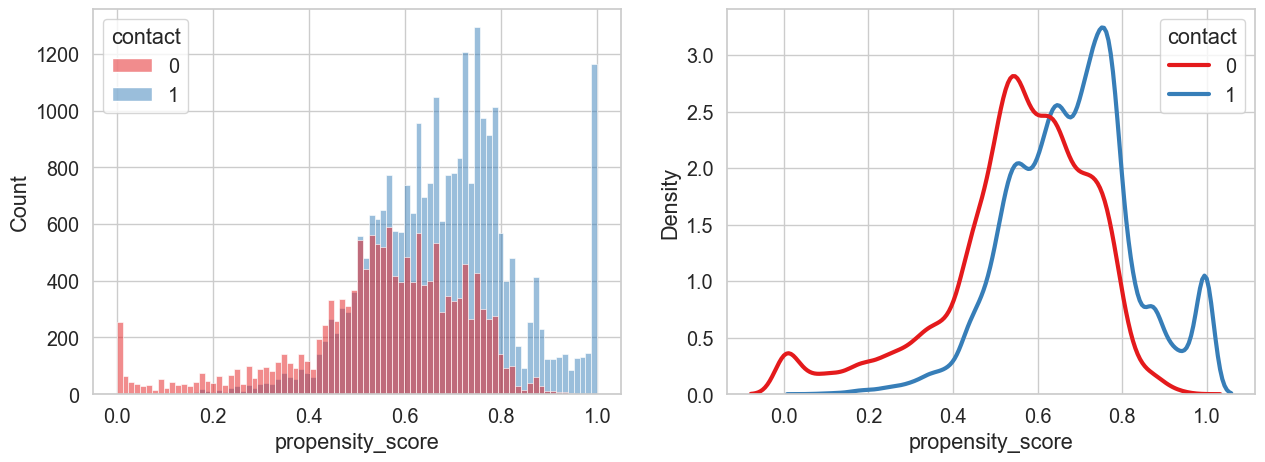

In [697]:
a = propensity_score_forest_graphics(df, 'contact', ['age', 'job', 'education'])

In [723]:
def propensity_score_forest_cal_graphics(df, treatment, confaunders):
    
 
    ps_model = RandomForestClassifier().fit(df[confaunders], df[treatment])
    
    prb = ps_model.predict_proba(df[confaunders])[:, 1].reshape(-1, 1) # прогностическая вероятность
    
    cal_model = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(prb, df[treatment]) # подгонка модели с его обучением
    
    df_ps = df.assign(propensity_score=cal_model.predict(prb))
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.histplot(data=df_ps, x='propensity_score', hue=treatment)
    plt.subplot(122)
    sns.kdeplot(data=df_ps, x='propensity_score', 
            hue=treatment, lw=3, common_norm=False)
    #plt.suptitle("Проверка на сопоставимость")
    plt.show();

    return df_ps

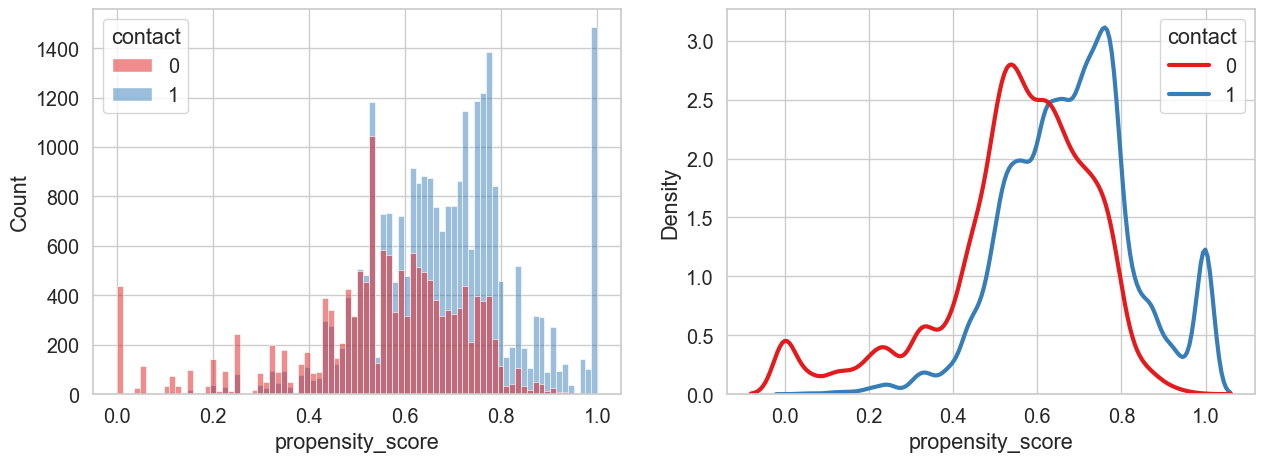

In [724]:
df_prop = propensity_score_forest_cal_graphics(df, 'contact', ['age', 'job', 'education'])

In [727]:
df_prop = df_prop[df_prop.propensity_score > 0.2][df_prop.propensity_score < 0.9]

/var/folders/3f/wwj0290s09x08d0h9h6gxccr0000gn/T/ipykernel_14575/3903704735.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_prop = df_prop[df_prop.propensity_score > 0.2][df_prop.propensity_score < 0.9]


In [732]:
def get_propensity_score_estimate(df, treatment, target):
    
    weight = (
        (df[treatment] - df["propensity_score"]) /
        (df["propensity_score"] * (1 - df["propensity_score"])))

    ate = np.mean(weight * df[target])

    return ate

In [740]:
ps_estimates = []

for _ in (range(10000)):
    
    tmp_df = df_prop.sample(frac = 0.8, replace = True)
    ps_estimates.append(get_propensity_score_estimate(tmp_df, 'contact', 'target'))


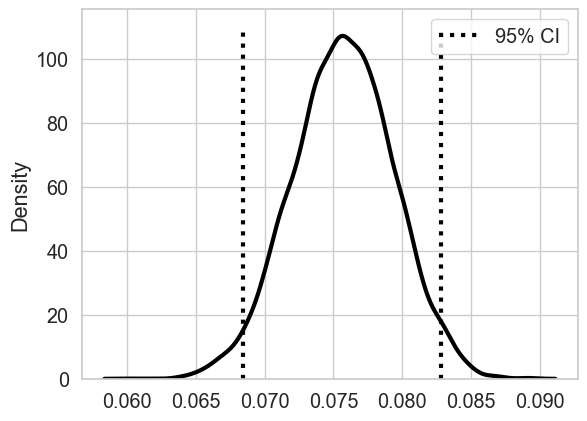

In [744]:
sns.kdeplot(ps_estimates, lw=3, color = 'black')
plt.vlines(np.percentile(ps_estimates, [2.5, 97.5]), 0, 110, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

## оценка с двойной надежностью

In [753]:
def doubly_robust_estimate(df, covariates, treatment, target):


    propensity_score_vec = df['propensity_score']
    
    
    
    # Оцениваем E(Y|X, T=0) для всех объектов
    model_0 = LogisticRegression(C=1e6, max_iter=10000)
    model_0.fit(df.query(f"{treatment}==0")[covariates], df.query(f"{treatment}==0")[target])
    mu0 = model_0.predict_proba(df[covariates])[:, 1]
    
    # Оцениваем E(Y|X, T=1) для всех объектов
    model_1 = LogisticRegression(C=1e6, max_iter=10000)
    model_1.fit(df.query(f"{treatment}==1")[covariates],df.query(f"{treatment}==1")[target])
    mu1 = model_1.predict_proba(df[covariates])[:, 1]
    
    mean_c1 = np.mean(df[treatment]*(df[target] - mu1)/propensity_score_vec + mu1)
    mean_c0 = np.mean((1-df[treatment])*(df[target] - mu0)/(1-propensity_score_vec) + mu0)
    
    return mean_c1 - mean_c0

In [755]:
doubly_robust_estimate(df = df_prop,
                       covariates = ['age', 'job', 'marital', 'education', 'housing', 'loan',
                                     'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
                       treatment = 'contact',
                       target = 'target')

In [791]:
dr_estimates = []

for _ in (range(1000)):
    
    tmp_df = df_prop.sample(frac = 0.8, replace = True)
    dr_estimates.append(doubly_robust_estimate(df = tmp_df,
                       covariates = ['age', 'job', 'marital', 'education', 'housing', 'loan',
                                     'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
                       treatment = 'contact',
                       target = 'target'))


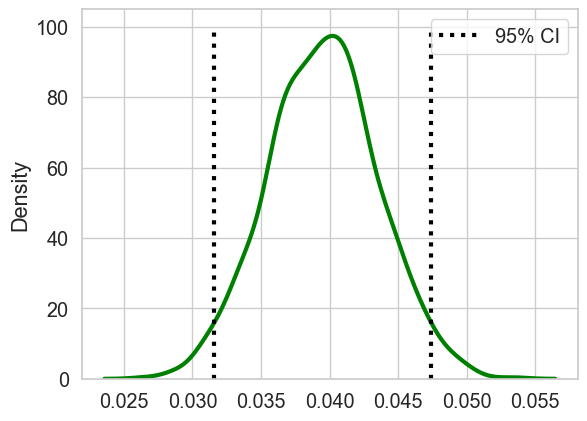

In [793]:
sns.kdeplot(dr_estimates, lw=3, color = 'green')
plt.vlines(np.percentile(dr_estimates, [2.5, 97.5]), 0, 100, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

### изменим воздействие на случайное

In [778]:
df_random_treatment = df.assign(random_treatment = np.random.binomial(size=df.shape[0], n=1, p= 0.5))

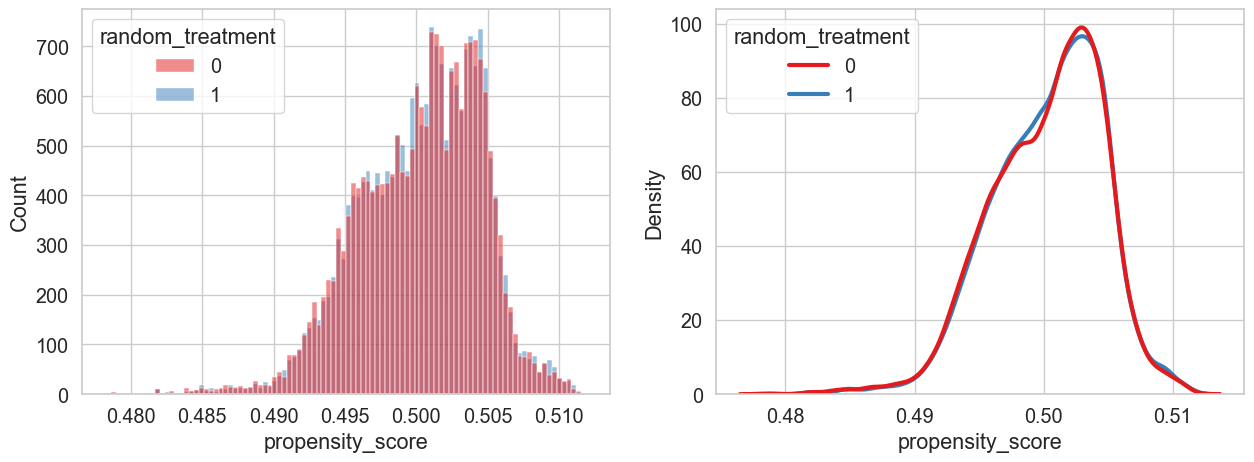

In [779]:
df_random_treatment = propensity_score_graphics(df_random_treatment, 'random_treatment', ['age', 'job', 'education'])

In [780]:
dr_estimates_random = []

for _ in (range(500)):
    
    tmp_df = df_random_treatment.sample(frac = 0.5, replace = True)
    dr_estimates_random.append(doubly_robust_estimate(df = tmp_df,
                       covariates = ['age', 'job', 'marital', 'education', 'housing', 'loan',
                                     'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
                       treatment = 'random_treatment',
                       target = 'target'))


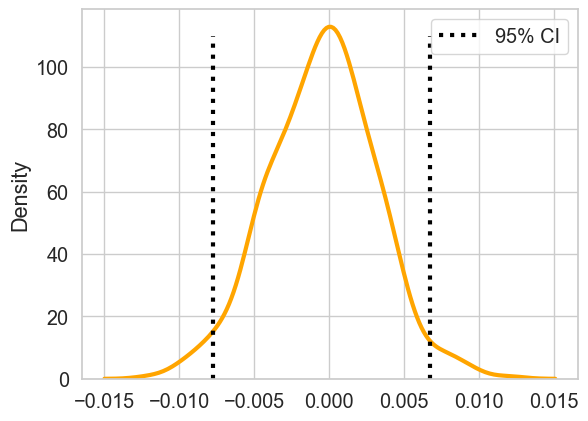

In [783]:
sns.kdeplot(dr_estimates_random, lw=3, color = 'orange')
plt.vlines(np.percentile(dr_estimates_random, [2.5, 97.5]), 0, 110, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

### изменим таргет на случайный

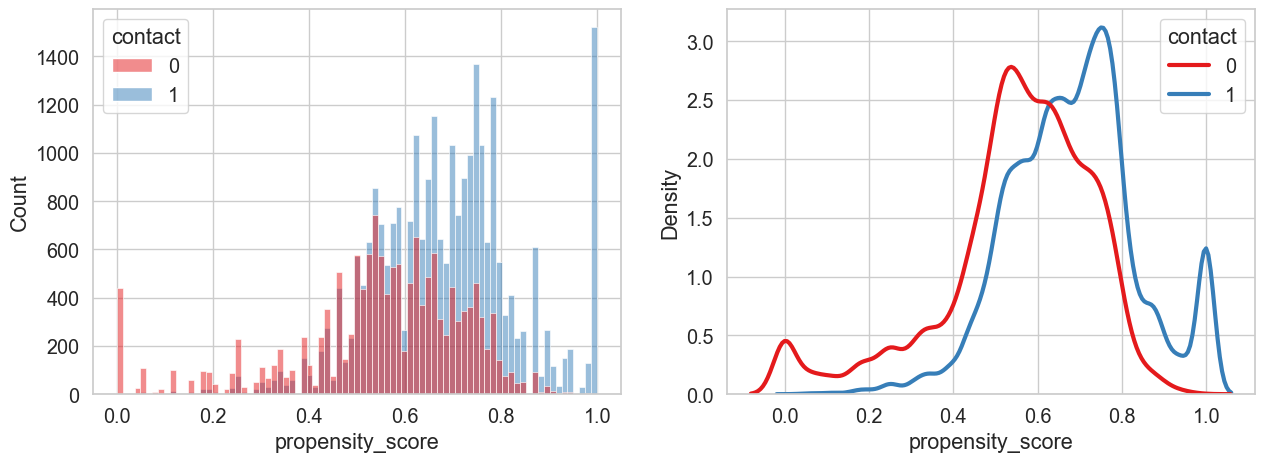

/var/folders/3f/wwj0290s09x08d0h9h6gxccr0000gn/T/ipykernel_14575/484624182.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_random_target = df_random_target[df_random_target.propensity_score > 0.2][df_random_target.propensity_score < 0.9]


In [787]:
df_random_target = propensity_score_forest_cal_graphics(df, 'contact', ['age', 'job', 'education'])
df_random_target = df_random_target[df_random_target.propensity_score > 0.2][df_random_target.propensity_score < 0.9]
df_random_target = df_random_target.assign(random_target = np.random.binomial(size=df_random_target.shape[0], n=1, p= 0.5))

In [788]:
dr_estimates_random_tar = []

for _ in (range(500)):
    
    tmp_df = df_random_target.sample(frac = 0.5, replace = True)
    dr_estimates_random_tar.append(doubly_robust_estimate(df = tmp_df,
                       covariates = ['age', 'job', 'marital', 'education', 'housing', 'loan',
                                     'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
                       treatment = 'contact',
                       target = 'random_target'))


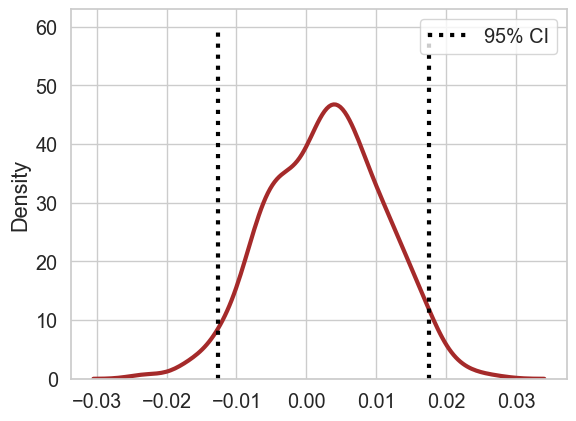

In [790]:
sns.kdeplot(dr_estimates_random_tar, lw=3, color = 'brown')
plt.vlines(np.percentile(dr_estimates_random_tar, [2.5, 97.5]), 0, 60, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

In [858]:
df.housing.value_counts(normalize = True)

housing
 1    0.523842
 0    0.452122
-1    0.024036
Name: proportion, dtype: float64

## housing

In [859]:
df_housing = df[df.housing != -1]

In [964]:
proportion_confint(df.query('housing==1').target.sum(), df.query('housing==1').target.count(), alpha = 0.05)

In [965]:
proportion_confint(df.query('housing==0').target.sum(), df.query('housing==0').target.count(), alpha = 0.05)

In [967]:
df.query('housing==1').target.mean()

In [968]:
df.query('housing==0').target.mean()

/var/folders/3f/wwj0290s09x08d0h9h6gxccr0000gn/T/ipykernel_14575/1744427846.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values2, y_values2, 'bo', linestyle="--", label = "Нулевая группа", color = 'r')


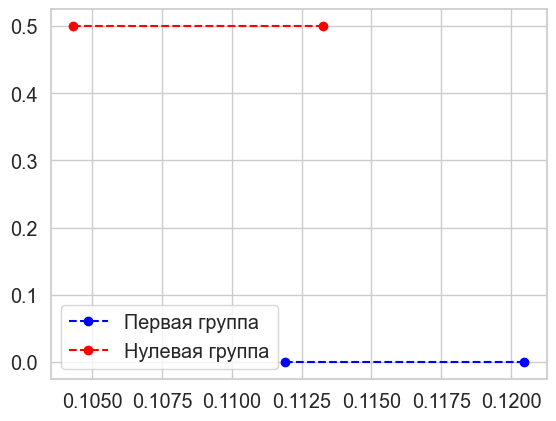

In [966]:
point1 = (0.111917967210357, 0)
point2 = (0.120469871128538, 0)
x_values1 = [point1[0], point2[0]]
y_values1 = [point1[1], point2[1]]
plt.plot(x_values1, y_values1, 'bo', linestyle="--", label = "Первая группа")

point3 = (0.10432375681976, 0.5)
point4 = (0.113268338551306, 0.5)
x_values2 = [point3[0], point4[0]]
y_values2 = [point3[1], point4[1]]
plt.plot(x_values2, y_values2, 'bo', linestyle="--", label = "Нулевая группа", color = 'r')
plt.legend()
#plt.text(point1[0]-0.015, point1[1]+0.25, "Point1")
#plt.text(point2[0]-0.050, point2[1]-0.25, "Point2")

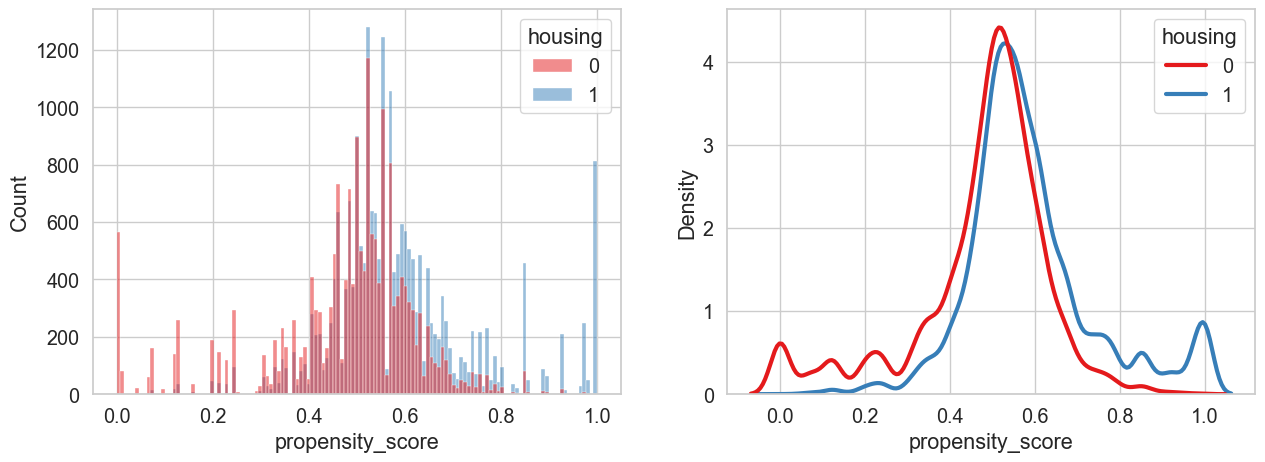

In [865]:
df_housing_ps = propensity_score_forest_cal_graphics(df_housing, 'housing', ['marital', 'job', 'education', 'age'])

In [866]:
df_housing_ps = df_housing_ps[df_housing_ps.propensity_score >= 0.2]
df_housing_ps = df_housing_ps[df_housing_ps.propensity_score <= 0.9]

In [868]:
get_propensity_score_estimate(df_housing_ps, 'housing', 'target')


In [876]:
ps_housing_estimates = []

for _ in (range(10000)):
    
    tmp_df = df_housing_ps.sample(frac = 0.8, replace = True)
    ps_housing_estimates.append(get_propensity_score_estimate(tmp_df, 'housing', 'target'))


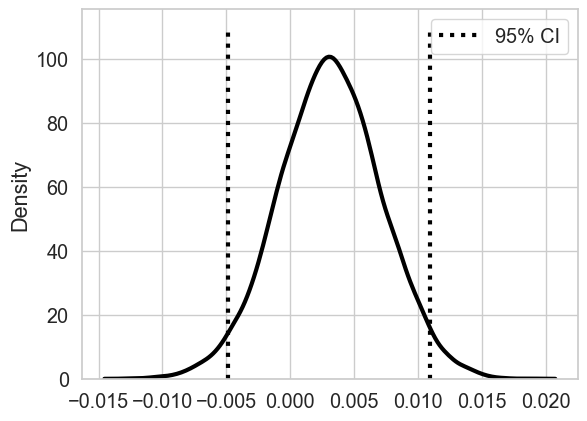

In [877]:
sns.kdeplot(ps_housing_estimates, lw=3, color = 'black')
plt.vlines(np.percentile(ps_housing_estimates, [2.5, 97.5]), 0, 110, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

In [884]:
doubly_robust_estimate(df = df_housing_ps,
                       covariates = ['age', 'job', 'marital', 'education', 'loan', 'contact',
                                     'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
                       treatment = 'housing',
                       target = 'target')

In [889]:
dr_housing_estimates = []

for _ in (range(500)):
    
    tmp_df = df_housing_ps.sample(frac = 0.8, replace = True)
    dr_housing_estimates.append(doubly_robust_estimate(df = tmp_df,
                       covariates = ['age', 'job', 'marital', 'education', 'loan', 'contact',
                                     'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
                       treatment = 'housing',
                       target = 'target'))


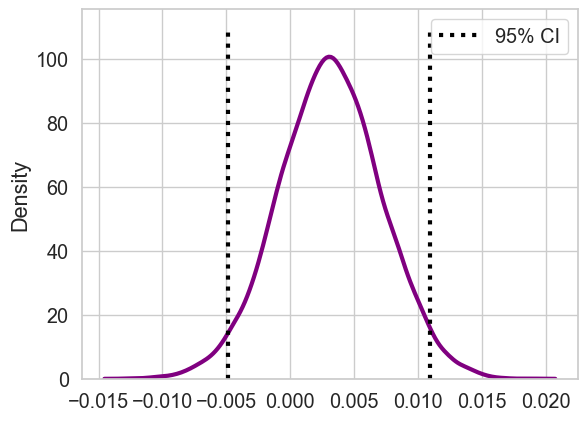

In [928]:
sns.kdeplot(ps_housing_estimates, lw=3, color = 'purple')
plt.vlines(np.percentile(ps_housing_estimates, [2.5, 97.5]), 0, 110, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

In [911]:
df_prev = df.copy()

In [913]:
df_prev['prev_flg'] = [1] * df_prev.shape[0]
df_prev.loc[df_prev.previous == 0, 'prev_flg'] = 0

In [936]:
df_prev.query('prev_flg == 1')['target'].mean()

In [937]:
df_prev.query('prev_flg == 0')['target'].mean()

In [920]:
df_prev.query('prev_flg == 1')['target'].mean() - df_prev.query('prev_flg == 0')['target'].mean()

In [929]:
proportion_confint(df_prev.query('prev_flg==1').target.sum(), df_prev.query('prev_flg==1').target.count(), alpha = 0.05)

In [930]:
proportion_confint(df_prev.query('prev_flg==0').target.sum(), df_prev.query('prev_flg==0').target.count(), alpha = 0.05)

/var/folders/3f/wwj0290s09x08d0h9h6gxccr0000gn/T/ipykernel_14575/3239400105.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values2, y_values2, 'bo', linestyle="--", label = "Нулевая группа", color = 'r')


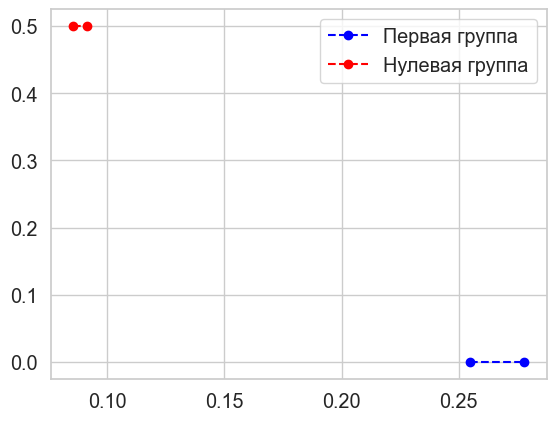

In [931]:
point1 = (0.254934958966922, 0)
point2 = (0.278042818810856, 0)
x_values1 = [point1[0], point2[0]]
y_values1 = [point1[1], point2[1]]
plt.plot(x_values1, y_values1, 'bo', linestyle="--", label = "Первая группа")

point3 = (0.0853729315344827, 0.5)
point4 = (0.0912713335725105, 0.5)
x_values2 = [point3[0], point4[0]]
y_values2 = [point3[1], point4[1]]
plt.plot(x_values2, y_values2, 'bo', linestyle="--", label = "Нулевая группа", color = 'r')
plt.legend()
#plt.text(point1[0]-0.015, point1[1]+0.25, "Point1")
#plt.text(point2[0]-0.050, point2[1]-0.25, "Point2")

In [918]:
matching_knn_estimate(df_prev, 'prev_flg')

In [934]:
knn_prev = []

for _ in (range(500)):
    
    tmp_df = df_prev.sample(frac = 0.8, replace = True)
    knn_prev.append(matching_knn_estimate(tmp_df, 'prev_flg'))


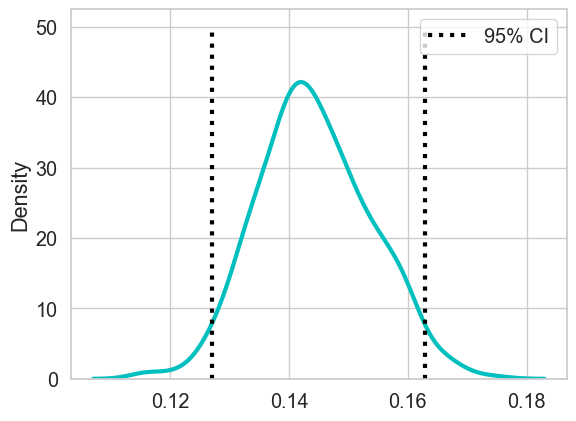

In [938]:
sns.kdeplot(knn_prev, lw=3, color = 'c')
plt.vlines(np.percentile(knn_prev, [2.5, 97.5]), 0, 50, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

### случайный таргет

In [940]:
df_prev_r1 = df_prev.copy()
df_prev_r1.target = np.random.binomial(size=df_prev_r1.shape[0], n=1, p= 0.5)

In [942]:
knn_prev_r1 = []

for _ in (range(500)):
    
    tmp_df = df_prev_r1.sample(frac = 0.8, replace = True)
    knn_prev_r1.append(matching_knn_estimate(tmp_df, 'prev_flg'))



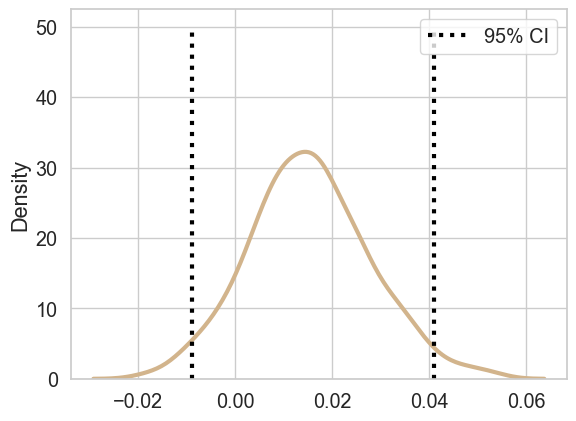

In [949]:
sns.kdeplot(knn_prev_r1, lw=3, color = 'tan')
plt.vlines(np.percentile(knn_prev_r1, [2.5, 97.5]), 0, 50, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();

###  случайное воздействие

In [944]:
df_prev_r2 = df_prev.copy()
df_prev_r2.prev_flg = np.random.binomial(size=df_prev_r2.shape[0], n=1, p= 0.5)

In [945]:
knn_prev_r2 = []

for _ in (range(500)):
    
    tmp_df = df_prev_r2.sample(frac = 0.8, replace = True)
    knn_prev_r2.append(matching_knn_estimate(tmp_df, 'prev_flg'))



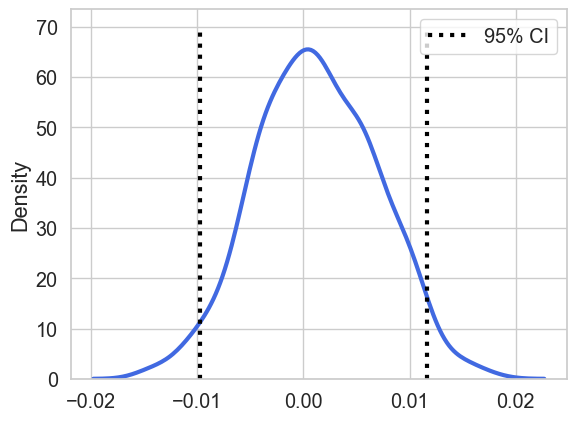

In [948]:
sns.kdeplot(knn_prev_r2, lw=3, color = 'royalblue')
plt.vlines(np.percentile(knn_prev_r2, [2.5, 97.5]), 0, 70, 
           color='black', lw=3, linestyles="dotted", label="95% CI")
plt.legend()
plt.show();